In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import os
import glob

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from pymono.config import mono_dark_6x6, mono_light_3x3, mono_light_6x6, mono_light_all_6x6

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import mean_rms, weighted_mean_and_sigma

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies
from pymono.plt_funcs import  plot_true_predicted, plotxyz

In [199]:
from pymono.cnn_func import MonoDataset, split_data, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [9]:
from pymono.cnn_func import test_loggin

In [10]:
test_loggin()

# Pymono

- Studies the use of a ConNN to reconstruct the positions (x,y,z) of impinging gammas in a monolithic crystal

## Setup

### dark 6 x 6

In [11]:
imgs6, mdata6 = select_image_and_metadata(mono_dark_6x6, 9)

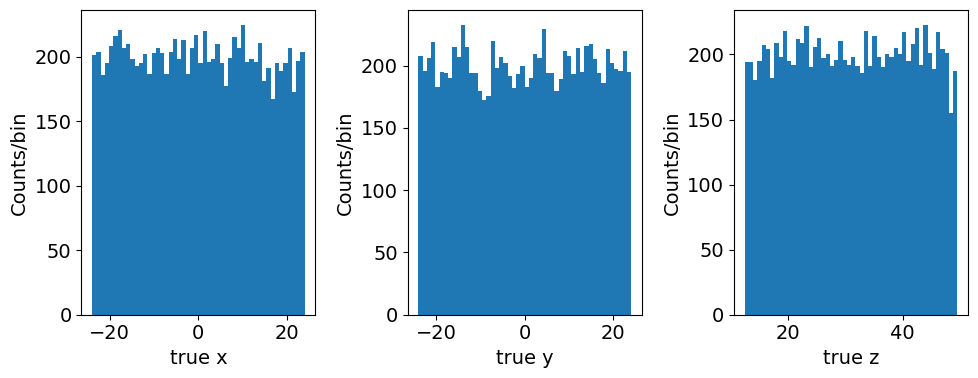

In [12]:
plot_true_positions(mdata6)

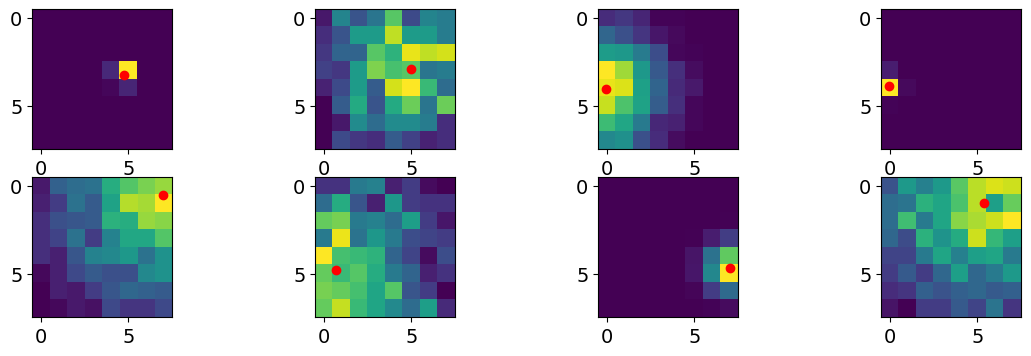

In [13]:
plot_images(imgs6, mdata6, range(0,8))

### Light 6 x 6

In [14]:
imgsl6, mdatal6 = select_image_and_metadata(mono_light_6x6, 9)

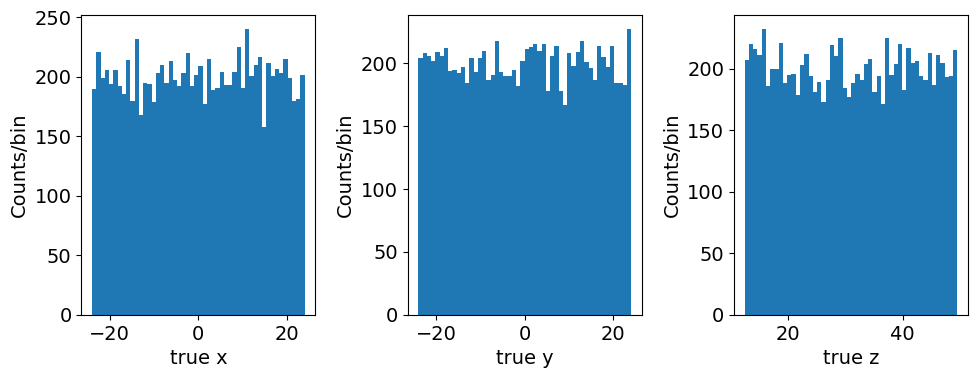

In [15]:
plot_true_positions(mdatal6)

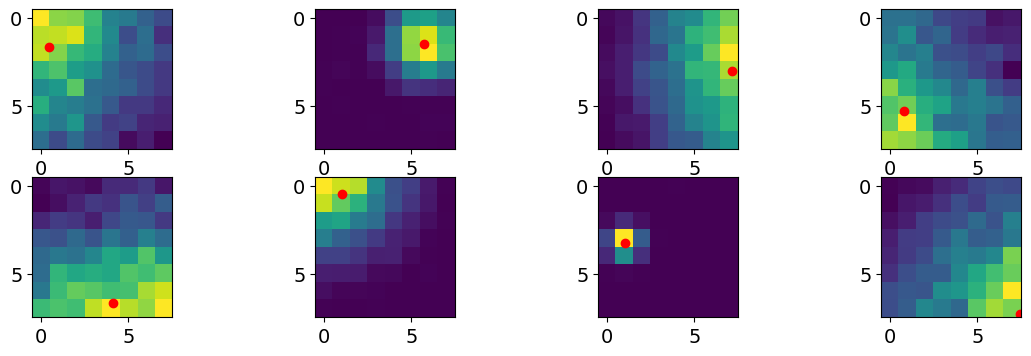

In [19]:
plot_images(imgsl6, mdatal6, range(0,8))

### Light 3 x 3

In [20]:
imgsl3, mdatal3 = select_image_and_metadata(mono_light_3x3, 9)

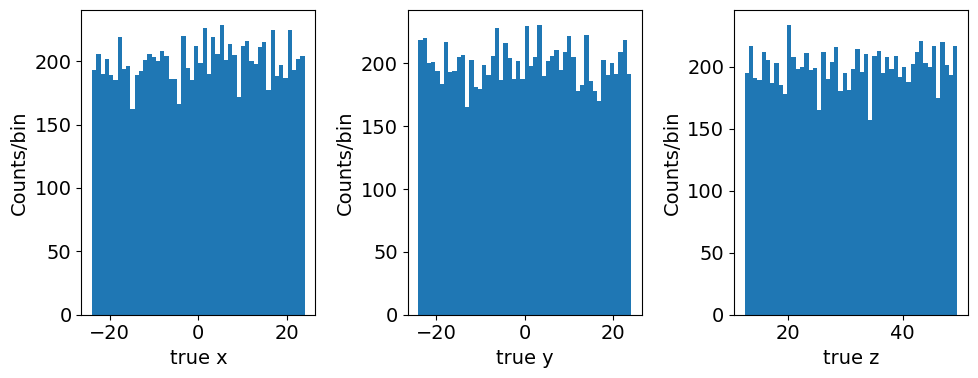

In [21]:
plot_true_positions(mdatal3)

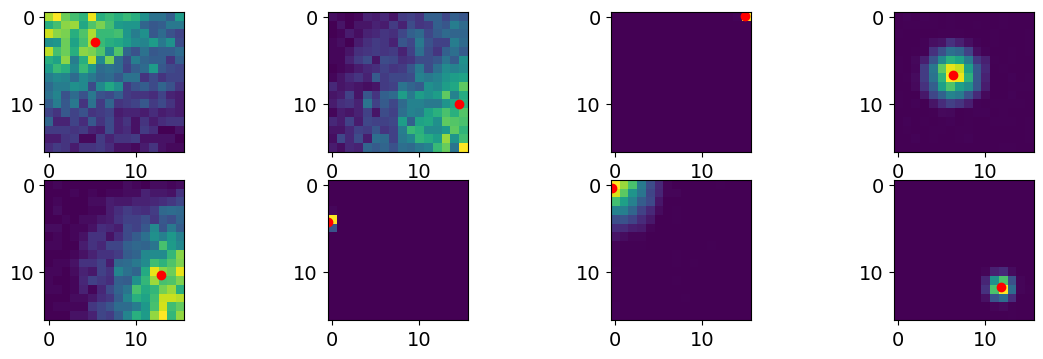

In [22]:
plot_images(imgsl3, mdatal3, range(0,8), pixel_size = 3, grid_size=16)

### Light All 6x6

In [23]:
imgsla6, mdatala6 = select_image_and_metadata(mono_light_all_6x6, 9)

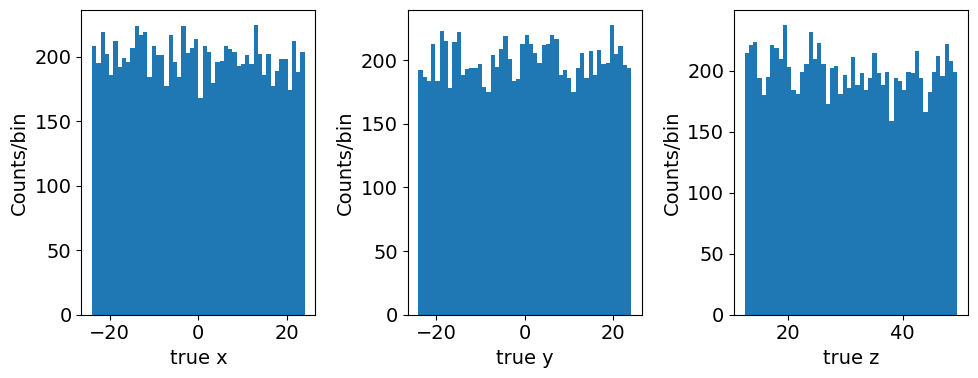

In [24]:
plot_true_positions(mdatala6)

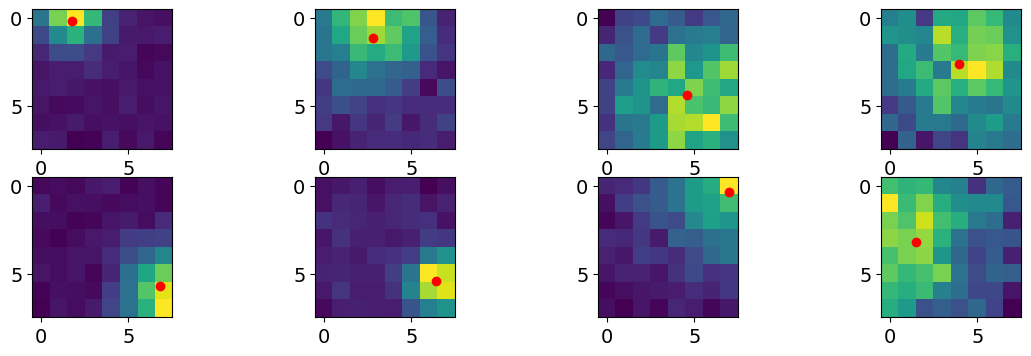

In [25]:
plot_images(imgsla6, mdatala6, range(0,8))

In [26]:
ene_light6x6 = energy(mono_light_6x6, 9)
ene_light_all_6x6 = energy(mono_light_all_6x6, 9)
ene_light3x3 = energy(mono_light_3x3, 9)
ene_dark6x6 = energy(mono_dark_6x6, 9)

In [27]:
mean6x6, std6x6, fwhm6x6 = mean_rms(ene_light6x6)
mean6x6a, std6x6a, fwhm6x6a = mean_rms(ene_light_all_6x6)
mean3x3, std3x3, fwhm3x3 = mean_rms(ene_light3x3)
mean6x6d, std6x6d, fwhm6x6d = mean_rms(ene_dark6x6)

print(f"resolution (FWHM): light 6x6     = {fwhm6x6:.2f}, light 3x3 = {fwhm3x3:.2f} ")
print(f"resolution (FWHM): light 6x6 all = {fwhm6x6a:.2f}, dark = {fwhm6x6d:.2f} ")

resolution (FWHM): light 6x6     = 0.05, light 3x3 = 0.04 
resolution (FWHM): light 6x6 all = 0.03, dark = 0.84 


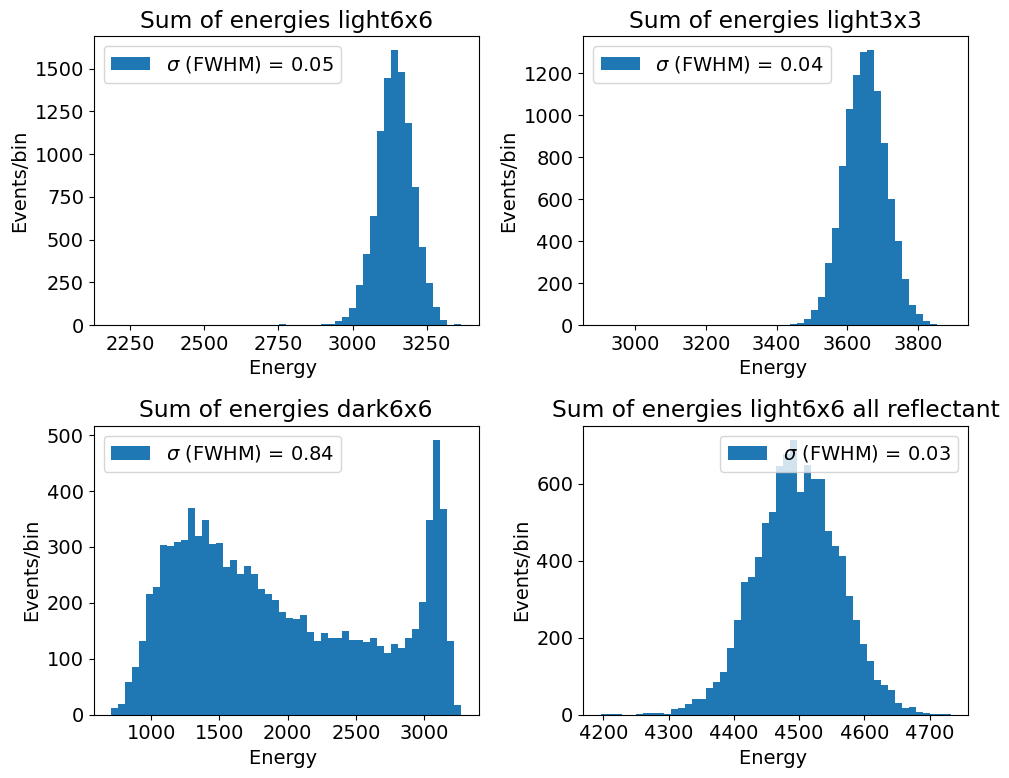

In [28]:
plot_energies(ene_light6x6, ene_light_all_6x6, ene_light3x3, ene_dark6x6)

In [220]:
first_file = 0  # initial file
last_file  = 10  # lasta file
batch_size = 1000  # Batch size
dataset = MonoDataset(mono_dark_6x6, first_file, last_file)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
ntot_evts = len(dataset)
print(f"Loaded {len(dataset)} events")
# Split the data into training, validation, and test sets
trsz = split_data(dataset, train_fraction=0.7, val_fraction=0.2)
print(f" train size = {trsz.train_size}")
print(f" val size = {trsz.val_size}")
print(f" test size = {trsz.test_size}")
print(f" train indices = {trsz.train_indices}")
print(f" val indices = {trsz.val_indices}")
print(f" test indices = {trsz.test_indices}")

Loaded 100000 events
 train size = 70000
 val size = 20000
 test size = 10000
 train indices = range(0, 70000)
 val indices = range(70000, 90000)
 test indices = range(90000, 100000)


## Data set

In [221]:
# Define subsets of the dataset
train_dataset = torch.utils.data.Subset(dataset, trsz.train_indices)
print(f"{len(train_dataset)} training events ({100*len(train_dataset)/ntot_evts}%)")
val_dataset = torch.utils.data.Subset(dataset, trsz.val_indices)
print(f"{len(val_dataset)} validation events ({100*len(val_dataset)/ntot_evts}%)")
test_dataset = torch.utils.data.Subset(dataset, trsz.test_indices)
print(f"{len(test_dataset)} test events ({100*len(test_dataset)/ntot_evts}%)")

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

70000 training events (70.0%)
20000 validation events (20.0%)
10000 test events (10.0%)


In [222]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[0.3750, 0.5750, 0.7500, 0.6250, 0.6750, 0.7250, 0.8000, 0.7000],
        [0.4750, 0.5750, 0.4750, 0.7250, 0.8000, 0.7250, 0.5250, 0.6750],
        [0.3750, 0.4750, 0.7000, 0.6250, 1.0000, 0.7000, 0.7500, 0.6750],
        [0.5000, 0.4750, 0.6250, 0.8000, 0.7750, 0.7750, 0.6250, 0.5000],
        [0.2750, 0.4750, 0.5500, 0.5750, 0.8000, 0.5500, 0.8000, 0.5000],
        [0.2500, 0.3500, 0.4250, 0.5500, 0.3500, 0.6250, 0.4750, 0.5000],
        [0.3000, 0.3250, 0.3250, 0.3500, 0.4250, 0.5000, 0.3250, 0.4750],
        [0.2250, 0.2500, 0.3500, 0.2250, 0.2250, 0.1500, 0.2750, 0.3500]])


In [223]:
img = images[0,0,:,:]
img

tensor([[0.3750, 0.5750, 0.7500, 0.6250, 0.6750, 0.7250, 0.8000, 0.7000],
        [0.4750, 0.5750, 0.4750, 0.7250, 0.8000, 0.7250, 0.5250, 0.6750],
        [0.3750, 0.4750, 0.7000, 0.6250, 1.0000, 0.7000, 0.7500, 0.6750],
        [0.5000, 0.4750, 0.6250, 0.8000, 0.7750, 0.7750, 0.6250, 0.5000],
        [0.2750, 0.4750, 0.5500, 0.5750, 0.8000, 0.5500, 0.8000, 0.5000],
        [0.2500, 0.3500, 0.4250, 0.5500, 0.3500, 0.6250, 0.4750, 0.5000],
        [0.3000, 0.3250, 0.3250, 0.3500, 0.4250, 0.5000, 0.3250, 0.4750],
        [0.2250, 0.2500, 0.3500, 0.2250, 0.2250, 0.1500, 0.2750, 0.3500]])

### Train the network with CNN_basic 

In [224]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [226]:
# Load the model.
model = CNN_basic(dropout=False).to(device)
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [227]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [228]:
epochs = 20

In [229]:

train_losses, val_losses =train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, epochs=epochs)

Running for epochs ->20
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 3])


INFO:--- EPOCH 0 AVG TRAIN LOSS: 39.40342903477805
INFO:--- EPOCH 0 AVG VAL LOSS: 4.704407382011413
INFO:--- EPOCH 1 AVG TRAIN LOSS: 1.7768871120044163
INFO:--- EPOCH 1 AVG VAL LOSS: 1.4242576837539673
INFO:--- EPOCH 2 AVG TRAIN LOSS: 1.5182387334959848
INFO:--- EPOCH 2 AVG VAL LOSS: 1.5521842956542968
INFO:--- EPOCH 3 AVG TRAIN LOSS: 1.3628223861966815
INFO:--- EPOCH 3 AVG VAL LOSS: 1.5816307842731476
INFO:--- EPOCH 4 AVG TRAIN LOSS: 1.3479750565120152
INFO:--- EPOCH 4 AVG VAL LOSS: 1.2840915858745574
INFO:--- EPOCH 5 AVG TRAIN LOSS: 1.3675285628863743
INFO:--- EPOCH 5 AVG VAL LOSS: 1.4017972469329834
INFO:--- EPOCH 6 AVG TRAIN LOSS: 1.2794586215700423
INFO:--- EPOCH 6 AVG VAL LOSS: 1.2264053225517273
INFO:--- EPOCH 7 AVG TRAIN LOSS: 1.2733612724712917
INFO:--- EPOCH 7 AVG VAL LOSS: 1.197570788860321
INFO:--- EPOCH 8 AVG TRAIN LOSS: 1.1803288800375802
INFO:--- EPOCH 8 AVG VAL LOSS: 1.1662537634372712
INFO:--- EPOCH 9 AVG TRAIN LOSS: 1.1799609695162092
INFO:--- EPOCH 9 AVG VAL LOSS: 1.

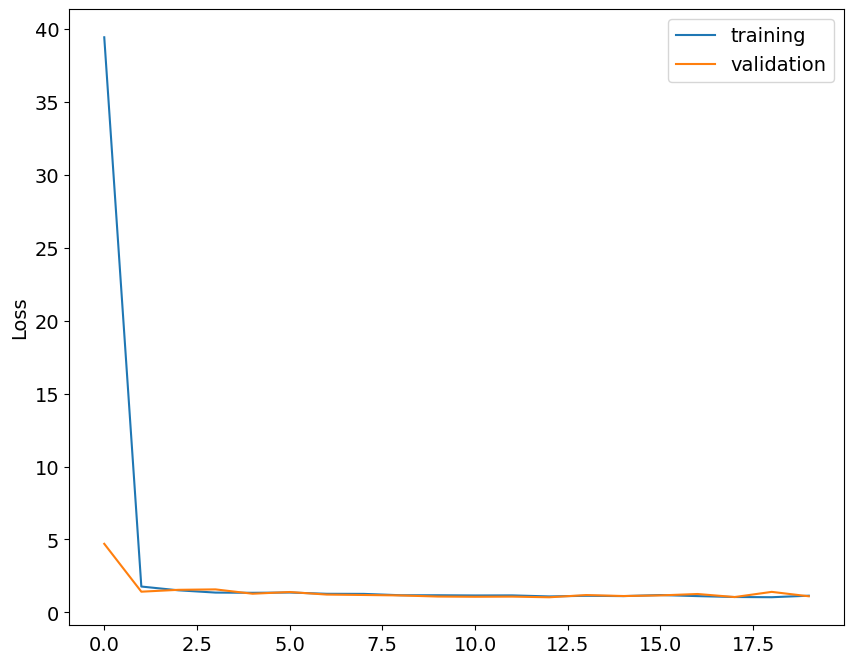

In [231]:
# Plot training and validation loss
xvals_train = np.arange(0,epochs,1)
xvals_val = np.arange(0,epochs,1)
plt.plot(xvals_train,train_losses,label='training')
plt.plot(xvals_val,val_losses,label='validation')
plt.ylabel("Loss")
plt.legend()

In [233]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

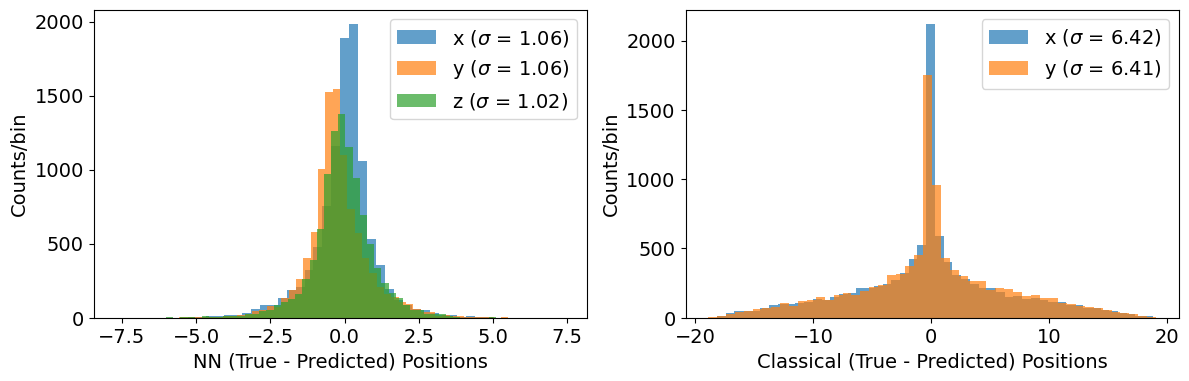

In [234]:
plot_true_predicted(tdeltas, nbins = 50)

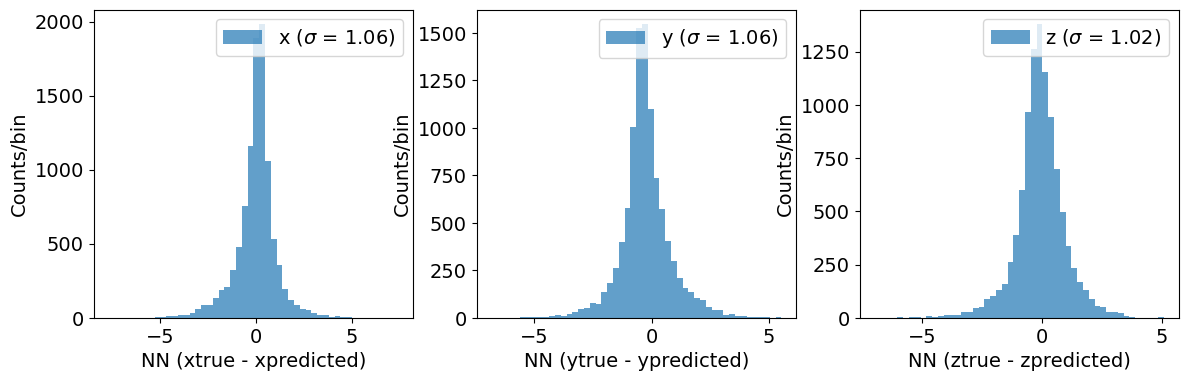

In [235]:
plotxyz(tdeltas, nbins=50)

In [236]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

In [237]:
train_losses, val_losses =train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, epochs=epochs)

Running for epochs ->10


INFO:--- EPOCH 0 AVG TRAIN LOSS: 0.9478704478059496
INFO:--- EPOCH 0 AVG VAL LOSS: 0.9721284478902816
INFO:--- EPOCH 1 AVG TRAIN LOSS: 0.9111074030399322
INFO:--- EPOCH 1 AVG VAL LOSS: 0.9633124589920044
INFO:--- EPOCH 2 AVG TRAIN LOSS: 0.9242442795208522
INFO:--- EPOCH 2 AVG VAL LOSS: 0.9655632227659225
INFO:--- EPOCH 3 AVG TRAIN LOSS: 0.9182912026132856
INFO:--- EPOCH 3 AVG VAL LOSS: 0.9571983009576798
INFO:--- EPOCH 4 AVG TRAIN LOSS: 0.9331059762409755
INFO:--- EPOCH 4 AVG VAL LOSS: 0.9592702090740204
INFO:--- EPOCH 5 AVG TRAIN LOSS: 0.9206485331058503
INFO:--- EPOCH 5 AVG VAL LOSS: 0.9861737161874771
INFO:--- EPOCH 6 AVG TRAIN LOSS: 0.9027045122214726
INFO:--- EPOCH 6 AVG VAL LOSS: 0.961968868970871
INFO:--- EPOCH 7 AVG TRAIN LOSS: 0.9011787056922913
INFO:--- EPOCH 7 AVG VAL LOSS: 0.9710562080144882
INFO:--- EPOCH 8 AVG TRAIN LOSS: 0.8737162709236145
INFO:--- EPOCH 8 AVG VAL LOSS: 0.9745824486017227
INFO:--- EPOCH 9 AVG TRAIN LOSS: 0.8954876618725913
INFO:--- EPOCH 9 AVG VAL LOSS: 

In [238]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)

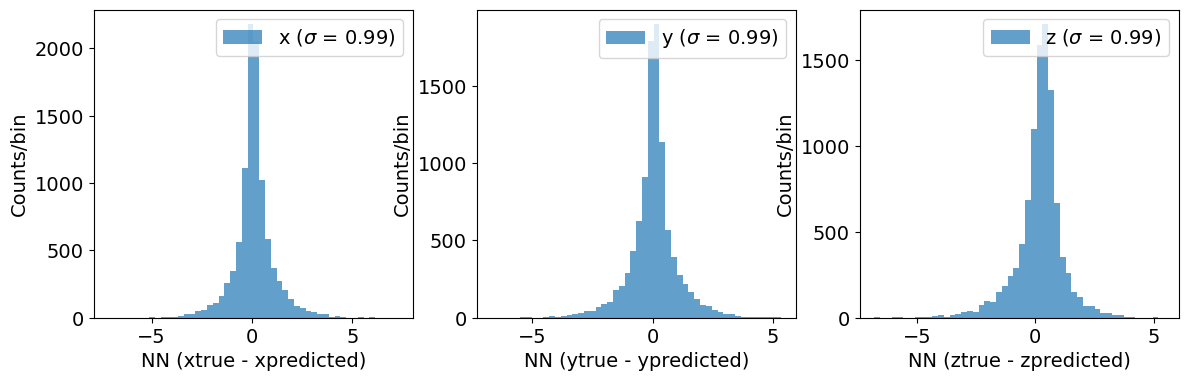

In [239]:
plotxyz(tdeltas, nbins=50)